# Multi objective geometric chain

Here we demonstrate how to solve a simple multi-objective problem via `pymoo`'s [NSGA2](https://pymoo.org/algorithms/moo/nsga2.html) algorithm within the `iwopy` framework.

The problem that we want to attack here is based on a chain of geometrically touching circles in two dimensions, for example representing a chain of marbles on a string. The marbles may have different radii, and each of them is allowed to touch two neighbours (except the outermost marbles, which have only one neighbour).

Our two objectives for this chain of blobs are:

- Maximize the extension of the overall chain in x-direction,
- Maximize the extension of the overall chain in y-direction.

Obviously these objectives are contradictory, and hence we can expect a nice and clean Pareto front when looking at solutions.

Here are the required imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from iwopy import Problem, Constraint, Objective
from iwopy.interfaces.pymoo import Optimizer_pymoo

First, we create a class that describes our chain of blobs. Actually, since we are planning to use `iwopy`'s fast vectorization capabilities, we directly implement a _population_ of chains. This means that each object of the class represents not one but `n_pop` chains, each containing `N` blobs. Note that the _individuals_ of a _population_ are completely independent of one another.

The geometry of a chain is descibed by `N-1` angles in degrees, giving the direction from one blob centre to the next. When combined with the information of the radii of the blobs and the location of the first blob in the chain, these angles fully determine the location of each blob. They will later serve as the optimization variables of the problem:

In [2]:
class ChainPopulation:
    """ A polulation of chains with N blobs """

    def __init__(self, n_pop, N, radii=1., xy0=0., alpha=0.):
        self.N = N
        self.n_pop = n_pop

        self.radii = np.zeros(N)
        self.radii[:] = radii

        self.xy = np.zeros((n_pop, N, 2))
        self.xy[:, 0] = xy0

        self.alpha = np.zeros((n_pop, N-1))
        self.dists = np.zeros((n_pop, N, N))
        self.set_alpha(alpha)
    
    def set_alpha(self, alpha):
        """ Set new alpha values and update data """
        self.alpha[:] = alpha
        arad = self.alpha*np.pi/180.
        uv = np.stack([np.cos(arad), np.sin(arad)], axis=-1)
        for i in range(1, self.N):
            self.xy[:, i] = self.xy[:, i-1] + uv[:, i-1] * (
                                self.radii[i-1] + self.radii[i])
        
        for i in range(self.N):
            d = self.xy - self.xy[:, i, None]
            self.dists[:, i] = np.linalg.norm(d, axis=-1)

    def get_fig(self, i=0, ax=None, title=None):
        """ Visualize the chain for a selected individual """
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.get_figure()
        xy = self.xy[i]
        for pi, pxy in enumerate(xy):
            ax.add_patch(plt.Circle(pxy, self.radii[pi], color='orange'))
        rmax = np.max(self.radii)
        xy_imin = np.argmin(xy, axis=0)
        xy_imax = np.argmax(xy, axis=0)
        xy_min = xy[xy_imin, range(2)] - rmax
        xy_max = xy[xy_imax, range(2)] + rmax
        xy_del = xy_max - xy_min
        ax.set_xlim((xy_min[0] - 0.1*xy_del[0], xy_max[0] + 0.1*xy_del[0]))
        ax.set_ylim((xy_min[1] - 0.1*xy_del[1], xy_max[1] + 0.1*xy_del[1]))
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"N = {self.N}" if title is None else title)
        return fig

Note the `get_fig` function which was added for results plotting in the end.

Next, we define an optimization problem whose optimization variables are the angles of the chain of blobs. Our intention is the evaluation in vectorized form, as mitigated by the `apply_population` function. Here this simply updates the `alpha` values of the chain to those given by the optimizer:

In [3]:
class ChainProblem(Problem):

    def __init__(self, chain):
        super().__init__(name="chain_problem")
        self.chain = chain

    def var_names_float(self):
        """ The variable names """
        return [f"alpha_{i:04}" for i in range(self.chain.N - 1)]

    def initial_values_float(self):
        """ The initial variable values """
        return self.chain.alpha[:-1]

    def min_values_float(self):
        """ The minimal variable values: 0 degrees """
        return np.full(self.chain.N - 1, 0.)

    def max_values_float(self):
        """ The maximal variable values: 360 degrees """
        return np.full(self.chain.N - 1, 360.)

    def apply_individual(self, vars_int, vars_float):
        """ Apply new variables from the optimizer """
        self.chain.set_alpha(vars_float[None, :])

    def apply_population(self, vars_int, vars_float):
        """ Apply new variables from the optimizer """
        self.chain.set_alpha(vars_float)

We want to avoid that the chain is crossing, or that any of the blobs that are not neighbours crash into each other. Let's introduce a constraint that prevent such solutions:

In [4]:
class NoCrossing(Constraint):
    """ The chain blobs are not allowed to cross """

    def __init__(self, problem, tol=1e-3):
        super().__init__(
            problem, "nocross", vnames_float=problem.var_names_float(), tol=tol
        )
        self.chain = problem.chain

    def n_components(self):
        """ Each blob touches two neighbours only """
        N = self.chain.N
        return int((N**2 - N - 2*(N - 1))/2)

    def calc_individual(self, vars_int, vars_float, problem_results, cmpnts=None):
        """ Positive values for too nearby 3rd and higher neighbours """
        rmin = np.min(self.chain.radii)
        values = np.zeros(self.n_components())
        i0 = 0
        for i in range(self.chain.N - 2):
            i1 = i0 + self.chain.N - 2 - i
            meet = self.chain.dists[0, i, i+2:] - self.chain.radii[i] - self.chain.radii[i+2:]
            values[i0:i1] = 0.1 * rmin - meet
            i0 = i1
        
        return values

    def calc_population(self, vars_int, vars_float, problem_results, cmpnts=None):
        """ Positive values for too nearby 3rd and higher neighbours """
        rmin = np.min(self.chain.radii)
        values = np.zeros((self.chain.n_pop, self.n_components()))
        i0 = 0
        for i in range(self.chain.N - 2):
            i1 = i0 + self.chain.N - 2 - i
            meet = self.chain.dists[:, i, i+2:] - self.chain.radii[i] - self.chain.radii[None, i+2:]
            values[:, i0:i1] = 0.1 * rmin - meet
            i0 = i1
        
        return values

For `N` blobs in the chain, this defines `(N**2 - N - (N - 1))/2` costraint component functions. Imagine a matrix with `N x N` entries. Since only 3rd neighbours onwards correspond to a constraint, and there is no need to repeat constraints for backward located blobs on the chain, this constraint number represents the upper-diagonal content of that matrix when ignoring the diagonal and also the secondary diagonal.

The objectives are straight-forward measures of the extension of given directions:

In [5]:

class MaxStretch(Objective):
    """ Aim for maximal stretch along a given direction """

    def __init__(self, problem, direction=np.array([0., 1.]), name="stretch"):
        super().__init__(problem, name, vnames_float=problem.var_names_float())
        self.chain = problem.chain
        self.direction = direction

    def n_components(self):
        """ There is only one component for this objective """
        return 1

    def maximize(self):
        """ The stretch length is to be maximized """
        return [True]

    def calc_individual(self, vars_int, vars_float, problem_results, cmpnts=None):
        """ Calculate the stretch length """
        u = np.einsum('cd,d->c', self.chain.xy[0], self.direction)
        return np.max(u + self.chain.radii) - np.min(u + self.chain.radii)

    def calc_population(self, vars_int, vars_float, problem_results, cmpnts=None):
        """ Calculate the stretch length """
        u = np.einsum('pcd,d->pc', self.chain.xy, self.direction)[:, :, None]
        return np.max(u + self.chain.radii[None, :, None], axis=1) - np.min(u - self.chain.radii[None, :, None], axis=1)


This completes our elements for the description of our optimization problem. So let's create the problem and add objectives and constraints, here for maximal radius `r = 5` and `n = 10` blobs per chain:

In [6]:
r = 5.0
n = 10
n_pop = 100

radii = np.random.uniform(r/2., r, n)
chain = ChainPopulation(n_pop, n, radii)

problem = ChainProblem(chain)
problem.add_constraint(NoCrossing(problem))
problem.add_objective(MaxStretch(problem, direction=np.array([1.,0.]), name="stretch_x"))
problem.add_objective(MaxStretch(problem, direction=np.array([0.,1.]), name="stretch_y"))
problem.initialize()

Problem 'chain_problem' (ChainProblem): Initializing
----------------------------------------------------
  n_vars_int  : 0
  n_vars_float: 9
----------------------------------------------------
  n_objectives: 2
  n_obj_cmptns: 2
----------------------------------------------------
  n_constraints: 1
  n_con_cmptns: 36
----------------------------------------------------


Notice that we selected `n_pop = 100` individuals per population. 

We would like to solve this problem using `pymoo`'s `NSGA2` algorithm. Here we create the corresponding solver object  and initialize it:

In [7]:
solver = Optimizer_pymoo(
    problem,
    problem_pars=dict(
        vectorize=True,
    ),
    algo_pars=dict(
        type="NSGA2",
        pop_size=n_pop,
        seed=42,
    ),
    setup_pars=dict(),
    term_pars=dict(
        type="default",
        n_max_gen=200,
        ftol=0,
        xtol=0,
    ),
)
solver.initialize()
solver.print_info()

Loading pymoo
pymoo successfully loaded
Initializing Optimizer_pymoo
Selecting sampling: float_random (FloatRandomSampling)
Selecting algorithm: NSGA2 (NSGA2)
Selecting termination: default (DefaultMultiObjectiveTermination)

Problem:
--------
  vectorize: True

Algorithm:
----------
  type: NSGA2
  pop_size: 100
  seed: 42

Termination:
------------
  n_max_gen: 200
  ftol: 0
  xtol: 0



Notice that we selected `n_max_gen = 200` generations in this setup. We are now ready to go! Let's run the solver:

In [8]:
results = solver.solve(verbosity=0)
solver.finalize(results)



Optimizer_pymoo: Optimization run finished
  Success: 100.00 %
  Best stretch_x = 74.52436382864866
  Best stretch_y = 74.47946961706329


All solution data is now contained in the `results` object. We can ask it to create a Pareto front plot:

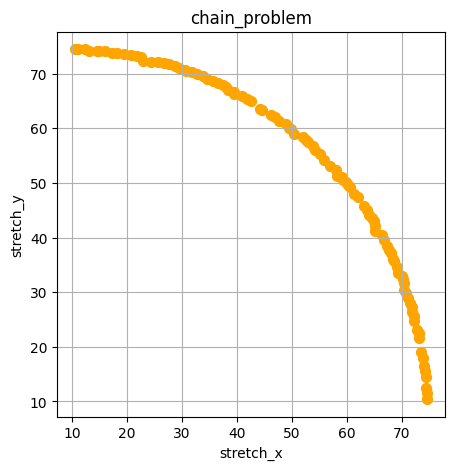

In [9]:
ax = results.plot_pareto()
plt.show()

One of the nice things about `NSGA2` is that it produces a well covered Pareto front in the final population. We can have a look at individuals, picking them according to weights of the objectives:

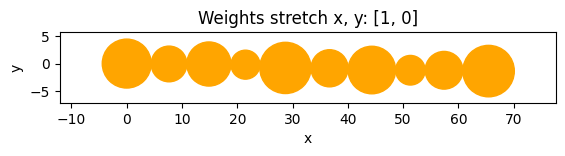

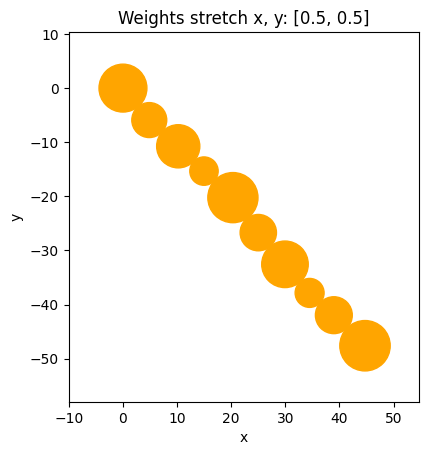

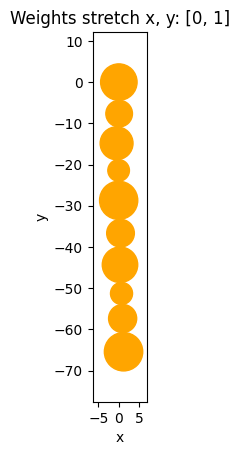

In [10]:
for w in [[1, 0], [0.5, 0.5], [0, 1]]:
    i = results.find_pareto_objmix(w, max=True)
    fig = chain.get_fig(i, title=f"Weights stretch x, y: {w}")

    plt.show()